<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/08-ensembles/Ensembles_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

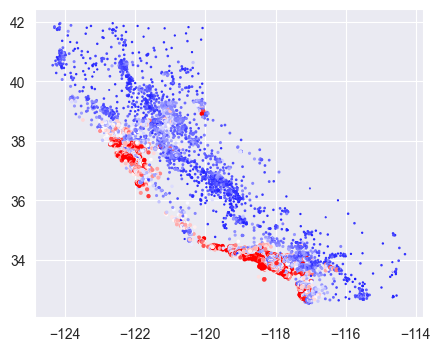

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [4]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [29]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_predict

In [30]:
knn = KNeighborsRegressor()
knn_selected_features = ['Longitude', 'Latitude']
knn_preprocessor = ColumnTransformer(
    [('selector', 'passthrough', knn_selected_features)],
    remainder='drop'
)

knn_pipeline = make_pipeline(
    knn_preprocessor,
    knn
)

knn_param_grid = {'kneighborsregressor__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]} # что-то как-то оптимизируем
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
knn_grid_search.fit(X_train, y_train)
best_knn_model = knn_grid_search.best_estimator_

In [33]:
rf = RandomForestRegressor()
rf_preprocessor = ColumnTransformer(
    [('selector', 'drop', knn_selected_features)],
    remainder='passthrough'
)

rf_pipeline = make_pipeline(
    rf_preprocessor,
    rf
)

rf_param_grid = {'randomforestregressor__n_estimators': [5, 10, 15], 'randomforestregressor__max_depth': [None, 10, 20]} # что-то как-то оптимизируем
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

In [39]:
stacking_regressor = StackingRegressor(estimators=[('knn', best_knn_model), ('rf', best_rf_model)], final_estimator=LinearRegression()) # Требуемый cv на 5 фолдов - вроде как дефлотный параметр cv судя по документации
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('knn',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('selector',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=7))])),
                              ('rf',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('selector',
                                                                                 'drop',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=10,
                                                                      n_estimators=15))]))],
                  final_estimator=LinearRegression())

In [43]:
stacking_preds = stacking_regressor.predict(X_test)
knn_preds = best_knn_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

In [44]:
knn_mse = mean_squared_error(y_test, knn_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
stacking_mse = mean_squared_error(y_test, stacking_preds)

print("Test MSE for kNN Regressor:", knn_mse)
print("Test MSE for Random Forest Regressor:", rf_mse)
print("Test MSE for Stacking Regressor:", stacking_mse)

Test MSE for kNN Regressor: 0.2940900880044799
Test MSE for Random Forest Regressor: 0.43760391846744956
Test MSE for Stacking Regressor: 0.23205499488799178


Видим, что объединение двух моделей смогло достичь лучшей ошибки, чем любая из двух моделей самостоятельно. Комбинируя области, в которых себя хорошо проявляет kNN и Случайный Лес, модели компенсируют недостатки друг друга и достигают лучшего качества.
Ладно, я просто не знаю, что ещё тут написать, вроде это ровно то, чего мы и ожидали, так что да. Код вот чуть-чуть почище решил сделать.